Project - Actor-critic

Christopher Pillay - 1362077

Siddeeq Laher - 1727869

Zaeem Asvat - 1748323 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%capture
!sudo apt-get update  
!sudo apt-get install -y build-essential autoconf libtool pkg-config \
       python3-dev python3-pip python3-numpy git libncurses5-dev \
       libzmq3-dev flex bison

In [7]:
%%capture
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install 

In [8]:
!pip3 install cmake==3.15.3
!pip3 install nle

     |████████████████████████████████| 16.5MB 216kB/s 
  Found existing installation: cmake 3.12.0
    Uninstalling cmake-3.12.0:
      Successfully uninstalled cmake-3.12.0
     |████████████████████████████████| 6.7MB 9.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/00/84/fc9dc13ee536ba5e6b8fd10ce368fea5b738fe394c3b296cde7c9b144a92/pybind11-2.6.1-py2.py3-none-any.whl
  Created wheel for nle: filename=nle-0.6.0-cp36-cp36m-linux_x86_64.whl size=2847880 sha256=0e6c1f8416ae789b27837c0edecadde05ea8ee9433371da75dbc07a10a5d99b5
  Stored in directory: /root/.cache/pip/wheels/b5/4d/7c/e4c74b776f945ec1bc9bf01dc94bc226e452cf7dd2aba347a2
Successfully built nle


In [10]:

from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.wrappers import Monitor
import nle
import matplotlib.pyplot as plt
import gym
import random
from collections import deque
import sys
from itertools import count
from collections import namedtuple
from torch.distributions import Categorical
from gym import spaces
import time
import torch
import torch.nn as nn #layers
import torch.nn.functional as F #activation functions
import torch.optim as optim #optimisers
import numpy as np #array operations
from gym import wrappers
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ActorCritic(nn.Module):
    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete, actor_linear_dims=2048, critic_linear_dims=512):
        super(ActorCritic, self).__init__()
        #self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

        self.stats_observation_space = observation_space["blstats"]
        self.map_observation_space = observation_space["glyphs"]
        self.stats_size = self.stats_observation_space.shape[0]
        self.input_shape = self.map_observation_space.shape
        self.n_actions = action_space.n

        # convolutional sub-network for processing glyphs
        self.convolutional_layer_1 = nn.Conv2d(in_channels=torch.from_numpy(np.array([1])),out_channels=32,kernel_size=4,stride=3)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=32)
        self.convolutional_layer_2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3,stride=2)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=64)
        self.convolutional_layer_3 = nn.Conv2d(in_channels=64,out_channels=64, kernel_size=2,stride=1)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=64)
  
        # get size of conv output
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[0],4,3),3,2),2,1)
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[1],4,3),3,2),2,1) 
        conv_out_size = convw*convh*64

        # self.fullconn1_dims = fullconn1_dims
        # self.fullconn2_dims = fullconn2_dims 

        self.actor_linear_1 = nn.Linear(conv_out_size + self.stats_size, actor_linear_dims)
        self.critic_linear_1 = nn.Linear(actor_linear_dims, critic_linear_dims)

        self.actor_linear_2 = nn.Linear(critic_linear_dims, self.n_actions) # policy
        self.critic_linear_2 = nn.Linear(critic_linear_dims, 1) # value


    def forward(self, observation):

        # configure glyphs input
        map = observation["glyphs"]
        map = torch.from_numpy(map).float().to(device)
        map = map.unsqueeze(0) 
        x1 = map.unsqueeze(1)
        
        # process glyphs data
        x = F.relu(self.batch_norm_1(self.convolutional_layer_1(x1)))
        x = F.relu(self.batch_norm_2(self.convolutional_layer_2(x)))
        x = F.relu(self.batch_norm_3(self.convolutional_layer_3(x)))
        conv_glyphs_out = (x.view(x.size(0),-1))

        # configure stats input
        stats = observation["blstats"]
        x2 = torch.from_numpy(stats).float().to(device)

        # concat stats with conv glyphs
        conv_glyphs_and_stats = torch.cat((torch.flatten(conv_glyphs_out), x2))

        x = F.relu(self.actor_linear_1(conv_glyphs_and_stats)) # actor 1
        x = F.relu(self.critic_linear_1(x)) # critic 1

        policy = F.softmax(self.actor_linear_2(x), -1) # actor 2
        value = self.critic_linear_2(x) # critic 2  

        return policy, value

    def conv2d_size_out(self, size, kernel_size, stride):
        return ((size - kernel_size) // stride)  + 1


In [2]:

# for saving video recording
# display = Display(visible=0,size=(600,600))
# display.start()

gamma = 0.99
log_interval=10
seed = 42        
env = gym.make("NetHackScore-v0")
env.seed(seed)
torch.manual_seed(seed)
learning_rate = 1e-5

# env = Monitor(env_to_wrap, '/content/drive/My Drive/videos/', video_callable=lambda episode_id: (episode_id+1)%100==0, force=True)

model = ActorCritic(env.observation_space, env.action_space, 2048, 512).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
eps = np.finfo(np.float32).eps.item()


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

def select_action(state):
    #state = torch.from_numpy(state).float()
    policy, value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(policy)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward(retain_graph=True)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def main():

    running_reward = 10

    num_runs = 1
    num_eps = 5000
    num_steps = 10000

    episode_rewards = [0.0] * (num_eps + 1)
    model_loss = [] 
    episode_loss = 0

    for i_runs in range(num_runs):
        
        # run inifinitely many episodes, but change this to around 5000 or 6000
        for i_episode in range(num_eps):

            # reset environment and episode reward
            state = env.reset()
            ep_reward = 0

            # for each episode, only run 9999 steps so that we don't 
            # infinite loop while learning
            for t in range(1, num_steps):

                # select action from policy
                action = select_action(state)

                # take the action
                state, reward, done, _ = env.step(action)

                #if render:
                #    env.render()

                model.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

            # add reward to episode_reward
            episode_rewards[i_episode + 1] += ep_reward

            # update cumulative reward
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

            # perform backprop
            finish_episode()

            # log results
            if i_episode % log_interval == 0:
                print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                      i_episode, ep_reward, running_reward))

          # check if we have "solved" the problem
        #if running_reward > env.spec.reward_threshold:
        #    print("Solved! Running reward is now {} and "
        #          "the last episode runs to {} time steps!".format(running_reward, t))
        #    break

    # average episode rewards
    episode_rewards = np.array(episode_rewards)
    episode_rewards /= num_runs

    #Plot rewards per episode
    plt.figure(figsize=(16,8))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.savefig('/content/drive/My Drive/ac_rewards_per_ep.png')
    plt.show()

    torch.save(model.state_dict(), '/content/drive/My Drive/ac.pth')
    env.close()
    # env_to_wrap.close()

NameError: ignored

In [ ]:


torch.save(model.state_dict(), '/content/drive/My Drive/ac.pth')

Episode 0	Last reward: -17.47	Average reward: 8.63
Episode 10	Last reward: -40.14	Average reward: -0.15
Episode 20	Last reward: -41.65	Average reward: -6.37
Episode 30	Last reward: 22.17	Average reward: -8.74
Episode 40	Last reward: -20.67	Average reward: -14.65
Episode 50	Last reward: -31.58	Average reward: -17.13
Episode 60	Last reward: -26.82	Average reward: -12.57
Episode 70	Last reward: -39.32	Average reward: -8.32
Episode 80	Last reward: -15.35	Average reward: -6.13
Episode 90	Last reward: 14.05	Average reward: -3.32
Episode 100	Last reward: -38.68	Average reward: -4.53
Episode 110	Last reward: 3.66	Average reward: -6.65
Episode 120	Last reward: -36.46	Average reward: -12.04
Episode 130	Last reward: 36.01	Average reward: -8.50
Episode 140	Last reward: -10.15	Average reward: -13.48
Episode 150	Last reward: -36.34	Average reward: -13.49
Episode 160	Last reward: -4.51	Average reward: -14.75
Episode 170	Last reward: -15.43	Average reward: -8.44
Episode 180	Last reward: 49.00	Average 

FileNotFoundError: ignored

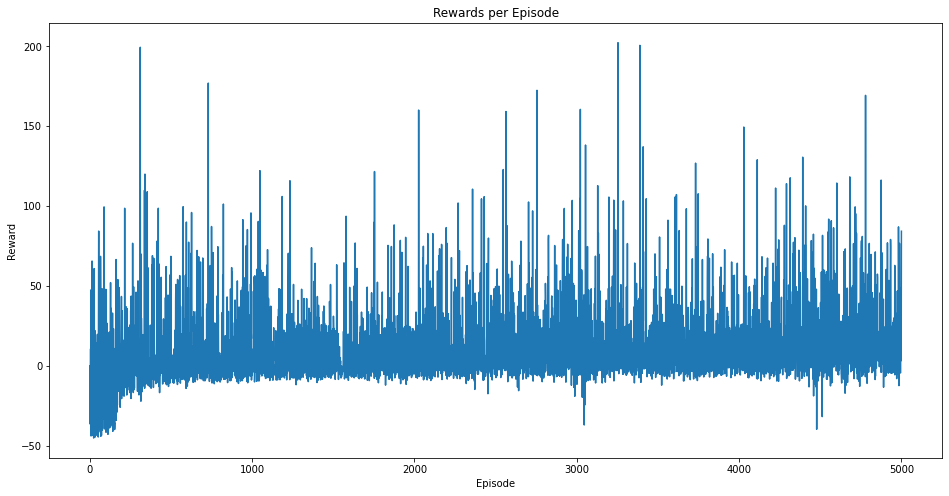

In [ ]:
if __name__ == '__main__':
    main()

In [11]:
class AbstractAgent:
    """
    AbstractAgent

    """

    def __init__(self, **kwargs):
        raise NotImplementedError()

    def act(self, observation):
        raise NotImplementedError()


class MyAgent(AbstractAgent):
    def __init__(self, observation_space, action_space, **kwargs):
        self.observation_space = observation_space
        self.action_space = action_space
        self.seeds = kwargs.get('seeds', None)
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = ActorCritic(self.observation_space, self.action_space, 2048, 512).to(device)
        self.model.load_state_dict(torch.load( '/ac_final.pth', map_location=torch.device(device)))

    def act(self, observation):
        # Perform processing to observation

        policy, value = self.model(observation)

        # create a categorical distribution over the list of probabilities of actions
        m = Categorical(policy)

        # and sample an action using the distribution
        action = m.sample()

        # # save to action buffer
        # model.saved_actions.append(SavedAction(m.log_prob(action), value))

        # the action to take (left or right)
        return action.item()


import numpy as np
import gym
import nle
import random
import csv
import os

def run_episode(env,seed,episode_num):
    # create instance of MyAgent
    # from MyAgent import MyAgent
    agent = MyAgent(env.observation_space, env.action_space)

    done = False
    episode_return = 0.0
    state = env.reset()
    stats_list = [np.zeros(25),np.zeros(25)]
    steps = 0
    max_depth = 0
    while not done:
        # pass state to agent and let agent decide action
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)
        steps += 1
        episode_return += reward
        # Update list of episode stats
        stats_list = update_stat_list(stats_list,state)
        if stats_list[0][12] > max_depth:
            max_depth = stats_list[0][12]
        # Check if done
        if done:
            row = get_stats(stats_list[0],steps,max_depth,seed,episode_num)

        state = new_state
    return episode_return,row

def get_stats(stats,steps,max_depth,seed,episode_num):
    return [1, # end_status, 1 = episode ended correctly. This is assumed here
        stats[9], # This is the ingame score, which may differ from the total returns
        stats[20], # time
        steps,stats[10], # steps in this episode
        stats[19], # health points
        stats[18], # experience
        stats[13], # experience level
        stats[21], # gold
        "UNK", # name of killer. env doesn't store this, so just left as unknown
        max_depth, # The furthest depth the agent went this episode
        episode_num, # The number of the episode
        seed, # The env seed
        "episode_"+str(episode_num)+".ttyrec"] # the name of the corresponding ttyrec file in stats.zip

def update_stat_list(stats_list,state):
    # Hacky stuff to get the right stats vector
    stats_list[0] = stats_list[1]
    stats_list[1] = list(state['blstats'])
    return stats_list


# if __name__ == '__main__':
# Directory
dir = os.getcwd()

# Seed
seeds = [1,2,3,4,5]

# Initialise environment
env = gym.make("NetHackScore-v0")

# Generate CSV
stats_list = [['end_status','score','time','steps','hp','exp','exp_lev',
'gold','hunger','killer_name','deepest_lev','episode','seeds','ttyrec']]

# Run one episode
rewards = []
episode_num = 1
for seed in seeds:
    env.seed(seed)
    seed_rewards = []
    reward,row = run_episode(env,seed,episode_num)
    stats_list.append(row)
    episode_num += 1
    rewards.append(reward)
# Close environment and print average reward
env.close()
print("Average Reward: %f" %(np.mean(rewards)))

# Write to csv
# NOTE: Unfortunately, you will need to either rename each ttyrec file to
#   match stats.csv or change the entry in stats.csv to point to the
#   appropriate ttyrec file
os.chdir(dir)
file = open('stats.csv','w+',newline='')
with file:
    writer = csv.writer(file)
    writer.writerows(stats_list)
file.close()


Average Reward: 27.014000
